In [29]:
import pandas as pd
import numpy as np

In [30]:
malicious_data = pd.read_csv(r'D:\kathan\python_codes\7th sem\ML lab\Project\malicious.csv')
benign_data = pd.read_csv(r'D:\kathan\python_codes\7th sem\ML lab\Project\benign.csv')

In [31]:
benign_df = benign_data.rename(columns={'text': 'Prompt'})
malicious_df = malicious_data.rename(columns={'Prompt': 'Prompt'})

In [32]:
benign_df['label'] = 0     
malicious_df['label'] = 1 

In [33]:
import re
import numpy as np

def safe_parse_embedding(x):
    try:
        x = str(x).strip()

        # handle [[...]] or malformed spacing
        if x.startswith('[[') and x.endswith(']]'):
            x = x[1:-1]

        # replace multiple spaces or tabs with commas
        x = re.sub(r'\s+', ',', x.strip())

        # parse into float array
        arr = np.fromstring(x.strip('[]'), sep=',')
        return arr
    except:
        return np.array([])


In [34]:
benign_data['embedding'] = benign_data['embedding'].apply(safe_parse_embedding)
malicious_data['embedding'] = malicious_data['embedding'].apply(safe_parse_embedding)


C:\Users\Kathan Vyas\AppData\Local\Temp\ipykernel_23664\1711702009.py:16: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  arr = np.fromstring(x.strip('[]'), sep=',')


In [35]:
import numpy as np, re

def parse_benign_emb(x):
    try:
        # clean standard JSON-like "[0.1, -0.2, ...]"
        arr = np.fromstring(x.strip('[]'), sep=',')
        return arr
    except:
        return np.zeros(384)

def parse_malicious_emb(x):
    try:
        # remove double brackets "[[...]]"
        x = x.strip()
        if x.startswith('[[') and x.endswith(']]'):
            x = x[1:-1]
        # replace spaces with commas for np.fromstring
        x = re.sub(r'\s+', ',', x)
        arr = np.fromstring(x.strip('[]'), sep=',')
        return arr
    except:
        return np.zeros(384)


benign_data['embedding'] = benign_data['embedding'].apply(parse_benign_emb)
malicious_data['embedding'] = malicious_data['embedding'].apply(parse_malicious_emb)


In [36]:
df = pd.concat([benign_df, malicious_df], ignore_index=True)

df.head()

,category,base_class,Prompt,embedding,label,Unnamed: 0.1,Unnamed: 0,idx,Length,Perplexity
0,conversation,conversation,"hi, how are you doing?","[0.6487895, -0.17706214, 0.26846254, 0.1890539...",0,NaN,NaN,NaN,NaN,NaN
1,conversation,conversation,hello! i am wonderful and yourself?,"[0.22256233, 0.26623946, 0.43933097, 0.3732961...",0,NaN,NaN,NaN,NaN,NaN
2,conversation,conversation,i am doing well. what are you up to?,"[0.5954824, -0.23374766, 0.19465648, 0.3015306...",0,NaN,NaN,NaN,NaN,NaN
3,conversation,conversation,just got in from my garden. i was seeing if my...,"[0.19071464, -0.10506695, -0.104982466, -0.219...",0,NaN,NaN,NaN,NaN,NaN
4,conversation,conversation,i am having dinner at my apartment with my 3 s...,"[0.5913735, -0.25481233, 0.14780612, 0.0823437...",0,NaN,NaN,NaN,NaN,NaN


In [37]:
df['label'].value_counts()

label
1    45504
0     1581
Name: count, dtype: int64

In [38]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df['label'] == 1]
df_minority = df[df['label'] == 0]

# Downsample majority class (malicious)
df_majority_downsampled = resample(
    df_majority,
    replace=False,                 # no duplicate samples
    n_samples=len(df_minority),    # match minority count
    random_state=42
)

# Combine balanced dataset
df_balanced = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the rows
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check new balance
print(df_balanced['label'].value_counts())


label
1    1581
0    1581
Name: count, dtype: int64


In [39]:
df_balanced.to_csv("new dataset.csv", index= False)

In [40]:
import re
import numpy as np

def parse_embedding_force(x):
    # Convert any input (string or list-like) into a numeric numpy array
    if isinstance(x, np.ndarray):
        return x  # already OK
    
    x = str(x).strip()
    
    # Remove double brackets
    if x.startswith('[[') and x.endswith(']]'):
        x = x[1:-1]
        
    # Replace multiple spaces or tabs with commas
    x = re.sub(r'\s+', ',', x)
    
    # Extract all numeric values using regex
    nums = re.findall(r'[-+]?\d*\.\d+|\d+', x)
    
    # Convert to float array
    arr = np.array([float(n) for n in nums], dtype=float)
    return arr

df_balanced['embedding'] = df_balanced['embedding'].apply(parse_embedding_force)



In [41]:
df_balanced = df_balanced[df_balanced['embedding'].apply(lambda e: len(e) > 0)]

In [43]:
X = np.vstack(df_balanced['embedding'].values)

y = df_balanced['label'].values

print("Labels distribution:\n", pd.Series(y).value_counts())


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 768 and the array at index 13 has size 385

Labels distribution after balancing and filtering:
 1    1581
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       317

    accuracy                           1.00       317
   macro avg       1.00      1.00      1.00       317
weighted avg       1.00      1.00      1.00       317

Accuracy: 1.0

Confusion matrix saved as 'confusion_matrix.png'


c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


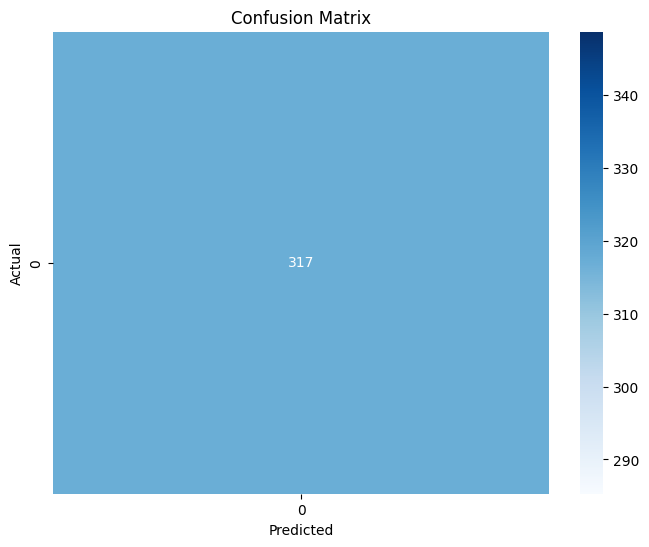

In [46]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Load the dataset
df = pd.read_csv('new dataset.csv')

# Assuming 'label' column exists as in your original code
if 'label' in df.columns:

    # Separate majority and minority classes
    df_majority = df[df['label'] == 1]
    df_minority = df[df['label'] == 0]

    # Downsample the larger class to balance the dataset
    if len(df_majority) > len(df_minority):
        df_majority_downsampled = resample(
            df_majority,
            replace=False,
            n_samples=len(df_minority),
            random_state=42
        )
        df_balanced = pd.concat([df_majority_downsampled, df_minority])
    elif len(df_minority) > len(df_majority):
        df_minority_downsampled = resample(
            df_minority,
            replace=False,
            n_samples=len(df_majority),
            random_state=42
        )
        df_balanced = pd.concat([df_minority_downsampled, df_majority])
    else:
        df_balanced = df.copy()

    # Shuffle the rows
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    def parse_embedding_force(x):
        if isinstance(x, np.ndarray):
            return x
        x = str(x).strip()
        if x.startswith('[[') and x.endswith(']]'):
            x = x[1:-1]
        x = re.sub(r'\s+', ',', x)
        nums = re.findall(r'[-+]?\d*\.\d+|\d+', x)
        return np.array([float(n) for n in nums], dtype=float)

    df_balanced['embedding'] = df_balanced['embedding'].apply(parse_embedding_force)

    # Find the most common embedding length and filter for it
    embedding_lengths = df_balanced['embedding'].apply(len)
    if not embedding_lengths.empty:
        most_common_length = embedding_lengths.mode()[0]
        df_balanced = df_balanced[embedding_lengths == most_common_length]

    # Convert the list of arrays into a 2D numpy array
    X = np.array(df_balanced['embedding'].tolist())
    y = df_balanced['label'].values

    print("Labels distribution after balancing and filtering:\n", pd.Series(y).value_counts())

    if X.shape[0] > 1:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Train the model
        clf = RandomForestClassifier(n_estimators=300, random_state=42)
        clf.fit(X_train, y_train)

        # Evaluate the model
        y_pred = clf.predict(X_test)

        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

        # Plotting Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.savefig('confusion_matrix.png')
        print("\nConfusion matrix saved as 'confusion_matrix.png'")
    else:
        print("Not enough data to train the model after filtering.")
else:
    print("The dataframe does not contain a 'label' column.")

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------- 8️⃣ Train model ----------
clf = RandomForestClassifier(n_estimators=300, random_state=42)
clf.fit(X_train, y_train)

# ---------- 9️⃣ Evaluate ----------
y_pred = clf.predict(X_test)


ValueError: setting an array element with a sequence.

In [ ]:
# Show label distribution in training set
pd.Series(y_train).value_counts()

1    1036
Name: count, dtype: int64

✅ Accuracy: 1.0

📊 Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00       259

    accuracy                           1.00       259
   macro avg       1.00      1.00      1.00       259
weighted avg       1.00      1.00      1.00       259



c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


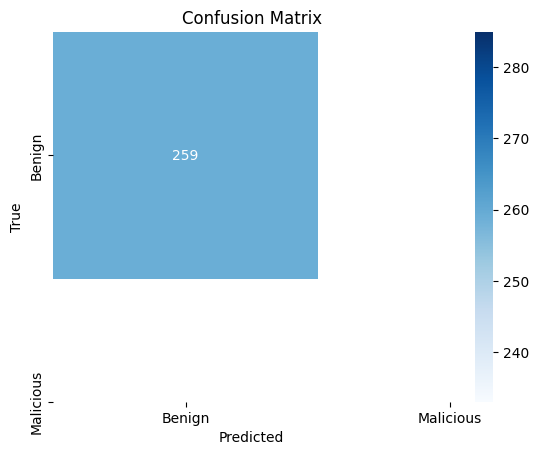

In [ ]:
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# ---------- 🔍 Optional: Confusion Matrix ----------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign','Malicious'], yticklabels=['Benign','Malicious'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()